In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pathlib
import yaml

yaml_path = pathlib.Path("./archive/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection") / "data.yaml"
with open(yaml_path, 'r') as f:
    data_cfg = yaml.safe_load(f)


train_images_dir = pathlib.Path("./archive/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection", data_cfg["train_images"])
train_labels_dir = pathlib.Path("./archive/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection",data_cfg["train_labels"])
train_images = list(train_images_dir.glob("*.jpg"))
class_names = data_cfg["names"]

print(train_images_dir)
print(f"Number of training images: {len(train_images)}")



archive\Human Bone Fractures Multi-modal Image Dataset (HBFMID)\Bone Fractures Detection\train\images
Number of training images: 1347


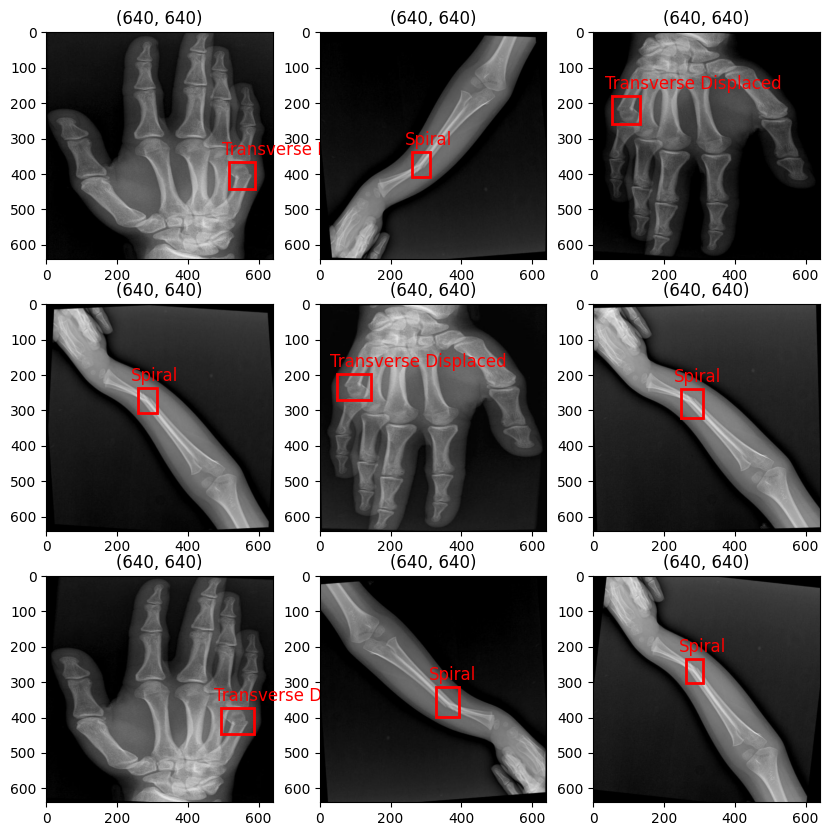

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = Image.open(train_images[i])
    ax.imshow(img)
    ax.set_title(img.size)
    # ax.axis("off")

    label_path = train_labes_dir / f"{train_images[i].stem}.txt"
    if label_path.exists():
        with open(label_path, "r") as f:
            lines = f.readlines()
        
        img_width, img_height = img.size
        for line in lines:
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])

            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)

            box_width = int(width * img_width)
            box_height = int(height * img_height)

            rect = patches.Rectangle((x1, y1), box_width, box_height, linewidth=2, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1-20, y1-20, class_names[class_id], color="r", fontsize=12)

In [ ]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.version.cuda}")  # Should match your installed CUDA (12.x)
print(f"CUDA available: {torch.cuda.is_available()}")  # Must be True

In [ ]:
from ultralytics import YOLO
import torch

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"GPU name: {torch.cuda.get_device_name(0) if device == 'cuda' else 'CPU'}")  # Show GPU info

# Load YOLO model
try:
    model = YOLO("./yolo11m.pt").to(device)
except:
    print("Custom weights not found, falling back to pretrained YOLOv8")
    model = YOLO("yolov8m.pt").to(device)  # Fallback to standard YOLOv8 medium

# Training parameters
config = {
    "data": "./archive/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/data.yaml",
    "epochs": 5,  # Increased from 20 as medical imaging often benefits from more epochs
    "imgsz": 640,
    "batch": 16 if device == 'cuda' else 4,  # Smaller batch for CPU
    "device": device,
    "project": "yolo_fracture_detection",
    "name": "exp1",
    "exist_ok": True,
    "optimizer": "AdamW",  # More modern optimizer
    "lr0": 0.001,  # Lower initial LR for fine-tuning
    "pretrained": True,
    "cos_lr": True,  # Cosine learning rate scheduler
    "weight_decay": 0.0005,  # Regularization
    "fliplr": 0.5,  # Horizontal flip augmentation
    "mosaic": 1.0,  # Mosaic augmentation
    "mixup": 0.2,  # Mixup augmentation
    "close_mosaic": 10,  # Disable mosaic last epochs
    "patience": 15,  # Early stopping patience
    "save_period": 5,  # Save checkpoint every 5 epochs
    "single_cls": False,  # Set True if you have only fracture/non-fracture
}

# Train the model
try:
    results = model.train(**config)
    print("Training completed successfully!")
except Exception as e:
    print(f"Training failed: {str(e)}")

In [ ]:
from ultralytics import YOLO

# Carica il modello addestrato
model = YOLO("yolo_fracture_detection/exp1/weights/best.pt")

# Valuta sul set di test definito nel file YAML
metrics = model.val(
    data="./archive/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/data.yaml",
    imgsz=640,
    batch=16,
)

print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob

# Carica il modello addestrato (usa il percorso al checkpoint migliore o l'ultimo)
model = YOLO('./yolo_fracture_detection/exp1/weights/best.pt')  # cambia il path se serve

# Cartella delle immagini di validazione
val_images_dir = './archive/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/valid/images'

# Prendi alcune immagini a caso dalla validazione
image_paths = glob(os.path.join(val_images_dir, '*.*'))[:10]  # prime 10 immagini, cambia se vuoi

for img_path in image_paths:
    # Carica immagine
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Fai predizione
    results = model(img_path)

    # Disegna le box con label e confidenza sull'immagine
    annotated_img = results[0].plot()

    # Mostra immagine
    h, w = annotated_img.shape[:2]
    plt.figure()
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.show()
